# Asthma Detection

## Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import (
    StratifiedKFold, 
    cross_validate, 
    train_test_split, 
    GridSearchCV
)
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer
)

from sklearn.ensemble import (
    RandomForestClassifier,
    IsolationForest
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from sklearn import tree
from PIL import Image

import shap
import pickle as pk
import os

import tkinter as tk
from tkinter import messagebox

/home/yash/Codes/ML/asthma-detection-ml/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
df=pd.read_csv('asthma_disease_data.csv')
df1=df

## EDA on original dataset

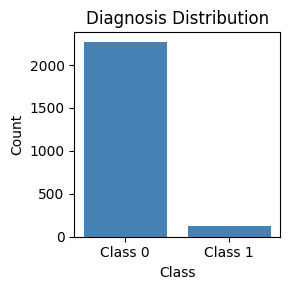

In [3]:
unique, counts = np.unique(df1['Diagnosis'], return_counts=True)

plt.figure(figsize=(3, 3))
plt.bar(unique, counts, color=['steelblue'])
plt.xticks([0, 1], labels=['Class 0', 'Class 1'])
plt.title('Diagnosis Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

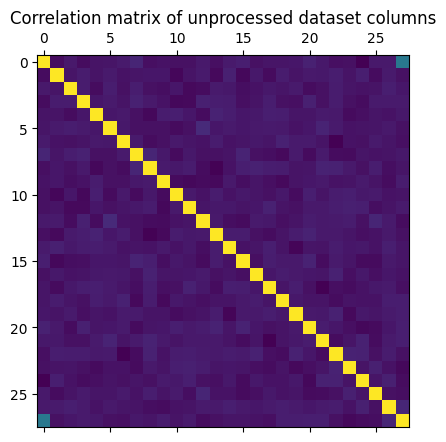

In [4]:
df1.drop('DoctorInCharge', axis=1, inplace=True)
plt.matshow(df1.corr())
plt.title('Correlation matrix of unprocessed dataset columns')
plt.show()

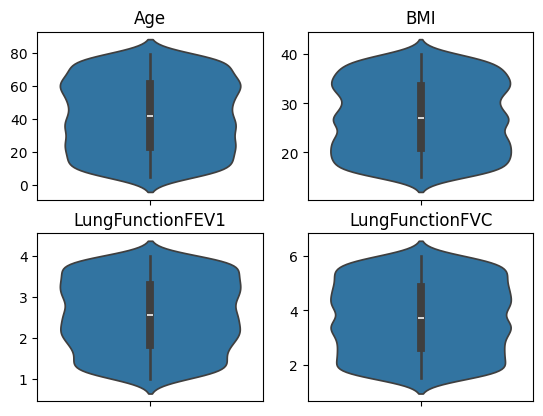

In [5]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

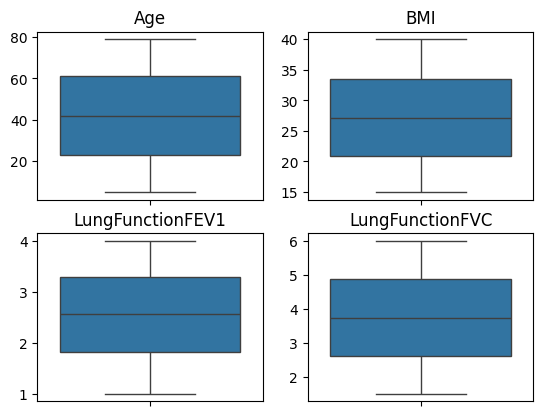

In [6]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


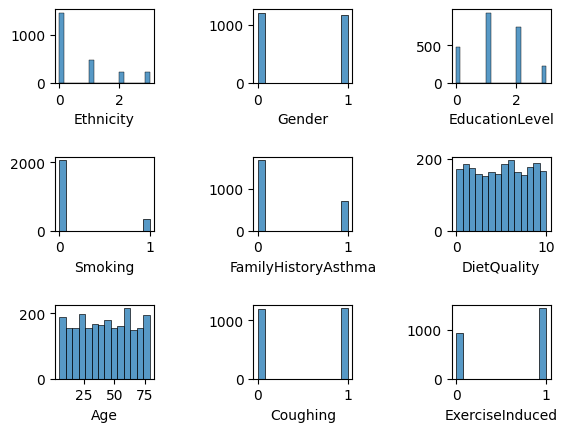

In [7]:
cols = ['Ethnicity', 'Gender', 'EducationLevel', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(df1[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



## Preprocessing

In [8]:
continuous_columns = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']
categorical_columns = ['Gender', 'Smoking']
# Simple Imputer
median_imputer = SimpleImputer(strategy='median')
df[continuous_columns] = median_imputer.fit_transform(df[continuous_columns])
df_new=pd.get_dummies(df, columns=['Ethnicity','EducationLevel'])
df=df_new
# One Hot Encoding
mode_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = mode_imputer.fit_transform(df[categorical_columns])
# Scaling
scaler = MinMaxScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

# IQR Outlier Removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in continuous_columns:
    df = remove_outliers(df, col)
df2=df.drop(columns=['Diagnosis','PatientID'], axis=1)
corr_matrix = df2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_clean = df2.drop(columns=to_drop)

### SMOTE

In [9]:
y = df1['Diagnosis']
X=df_clean
print(X.columns)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=69)
X_res, y_res = smote.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)
print(y_res.value_counts())

Index(['Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure',
       'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema',
       'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1',
       'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness',
       'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Ethnicity_0',
       'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_0',
       'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3'],
      dtype='object')
(4536, 32)
(4536,)
Diagnosis
0    2268
1    2268
Name: count, dtype: int64


### Isolation Forest

Train set outliers:  3004
Train set inliers:  1532


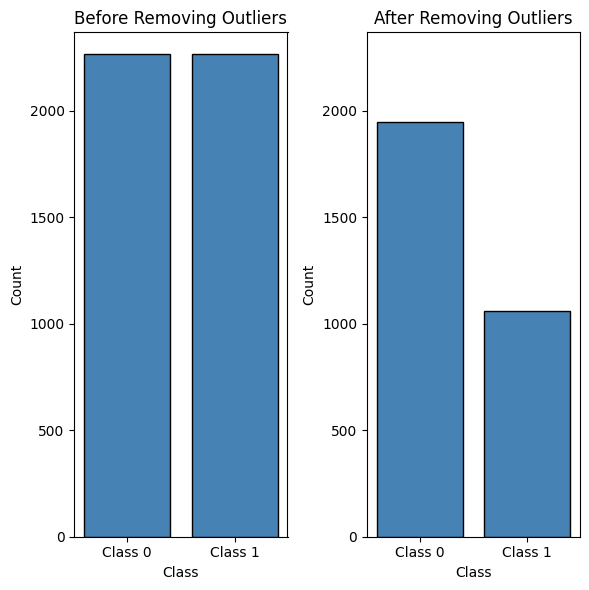

In [10]:
clf = IsolationForest(random_state=69)
clf.fit(X_res)
y_pred_res = clf.predict(X_res)
print("Train set outliers: ", len(y_pred_res[y_pred_res == -1]))
print("Train set inliers: ", len(y_pred_res[y_pred_res == 1]))

X_res_clean = X_res[y_pred_res == -1]
y_res_clean = y_res[y_pred_res == -1]

unique, counts = np.unique(y_res, return_counts=True)
unique_clean, counts_clean = np.unique(y_res_clean, return_counts=True)
max_count = max(max(counts), max(counts_clean))


plt.figure(figsize=(6, 6))

# Class distribution before removing outliers
plt.subplot(1, 2, 1)
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xticks([0, 1], labels=['Class 0', 'Class 1'])
plt.title('Before Removing Outliers')
plt.xlabel('Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 100)

# Class distribution after removing outliers
plt.subplot(1, 2, 2)
plt.bar(unique_clean, counts_clean, color='steelblue', edgecolor='black')
plt.xticks([0, 1], labels=['Class 0', 'Class 1'])
plt.title('After Removing Outliers')
plt.xlabel('Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

In [11]:
y_res_clean = y_res_clean.reset_index(drop=True)
X_res_clean = X_res_clean.reset_index(drop=True)

y_res = y_res_clean
X_res = X_res_clean

## EDA on preprocessed dataset

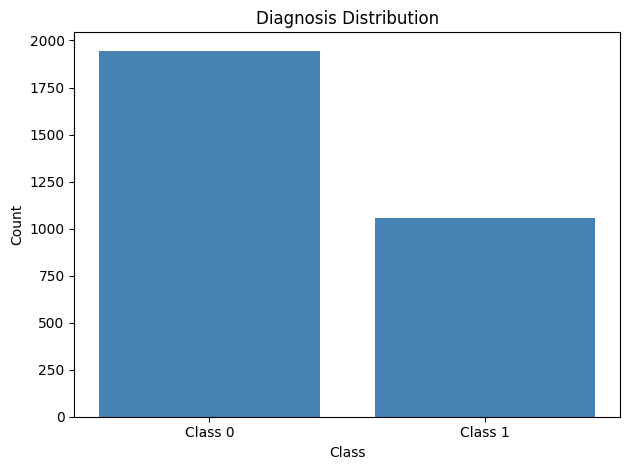

In [12]:
unique, counts = np.unique(y_res, return_counts=True)

plt.figure()
plt.bar(unique, counts, color=['steelblue'])
plt.xticks([0, 1], labels=['Class 0', 'Class 1'])
plt.title('Diagnosis Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

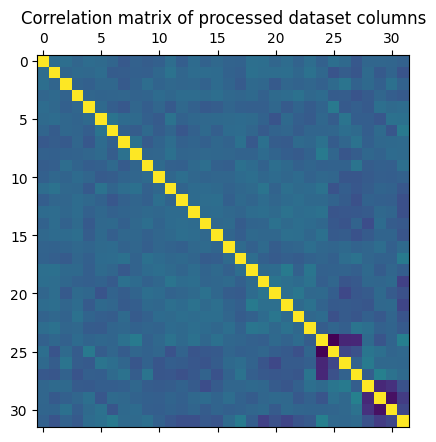

In [13]:
plt.matshow(X_res.corr())
plt.title('Correlation matrix of processed dataset columns')
plt.show()

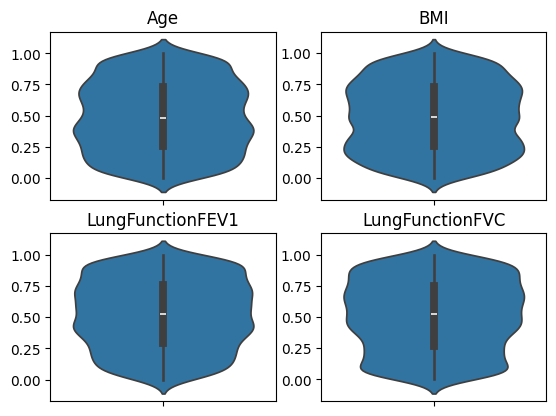

In [14]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(X_res[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

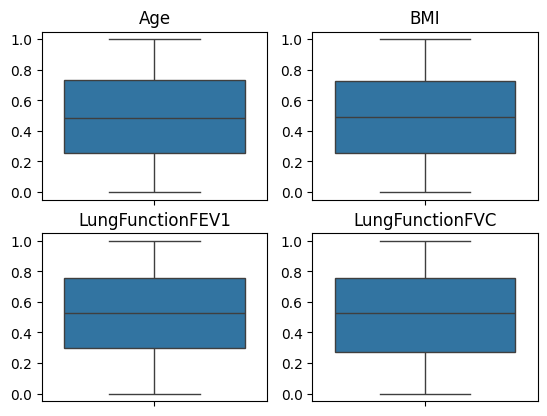

In [15]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(X_res[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


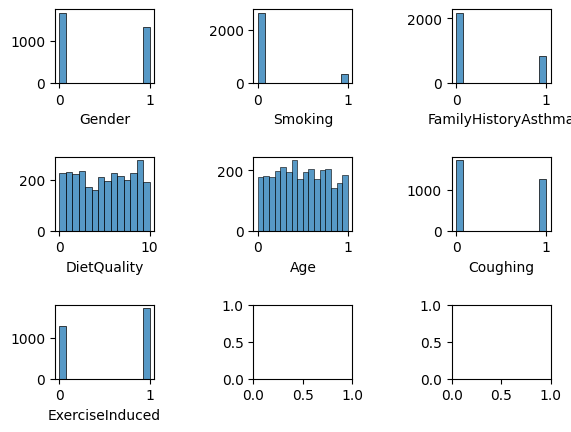

In [16]:
cols = ['Gender', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(X_res[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



## Supervised Learning Models

In [17]:
def scores(y_test, pred):
    print("Accuracy: ",accuracy_score(y_test, pred))
    print("Precision: ",precision_score(y_test, pred))
    print("Recall: ",recall_score(y_test, pred))
    print("F1 Score: ",f1_score(y_test, pred))
    print("ROC AUC Score: ",roc_auc_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=69)

### Logistic Regression

Logistic Regression Classifier
Accuracy:  0.9445676274944568
Precision:  1.0
Recall:  0.8603351955307262
F1 Score:  0.924924924924925
ROC AUC Score:  0.9301675977653632
[[272   0]
 [ 25 154]]


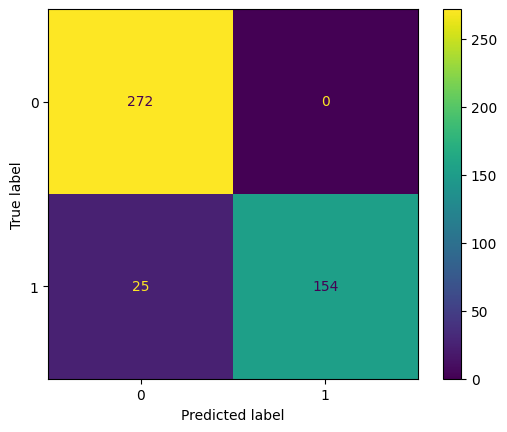

In [18]:
lgr = LogisticRegression(max_iter=1000)
cv_results = cross_validate(lgr, X_train, y_train, cv=skf, scoring=scoring)
print("Logistic Regression Classifier")
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
scores(y_test, y_pred)
with open('models/lgr.pkl', 'wb') as f:
    pk.dump(lgr, f)

### Decision Tree

Decision Tree Classifier
Accuracy:  0.9090909090909091
Precision:  0.8631578947368421
Recall:  0.9162011173184358
F1 Score:  0.8888888888888888
ROC AUC Score:  0.9103064410121591
[[246  26]
 [ 15 164]]


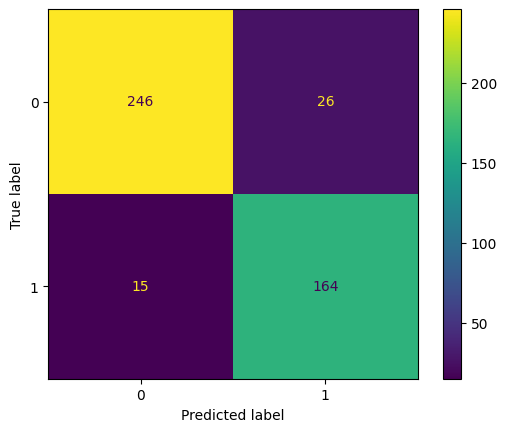

In [19]:
dt=DecisionTreeClassifier(random_state=69)
cv_results = cross_validate(dt, X_train, y_train, cv=skf, scoring=scoring)
print("Decision Tree Classifier")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
scores(y_test, y_pred)
with open('models/dt.pkl', 'wb') as f:
    pk.dump(dt, f)

### Random Forest

Random Forest Classifier
Accuracy:  0.9645232815964523
Precision:  0.9939393939393939
Recall:  0.9162011173184358
F1 Score:  0.9534883720930233
ROC AUC Score:  0.9562623233651003
[[271   1]
 [ 15 164]]


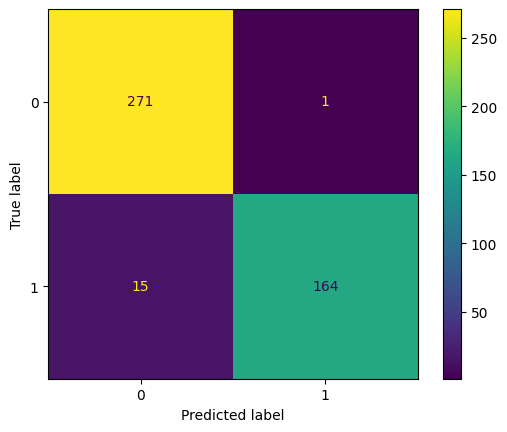

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=69)
rf=RandomForestClassifier(random_state=20)
cv_results = cross_validate(rf, X_train, y_train, cv=skf, scoring=scoring)
rf.fit(X_train, y_train)
print("Random Forest Classifier")
y_pred = rf.predict(X_test)
scores(y_test, y_pred)
with open('models/rf.pkl', 'wb') as f:
    pk.dump(rf, f)

### Support Vector Machine (SVM)

SVM Classifier
Accuracy:  0.9223946784922394
Precision:  0.9931506849315068
Recall:  0.8100558659217877
F1 Score:  0.8923076923076924
ROC AUC Score:  0.9031896976667763
[[271   1]
 [ 34 145]]


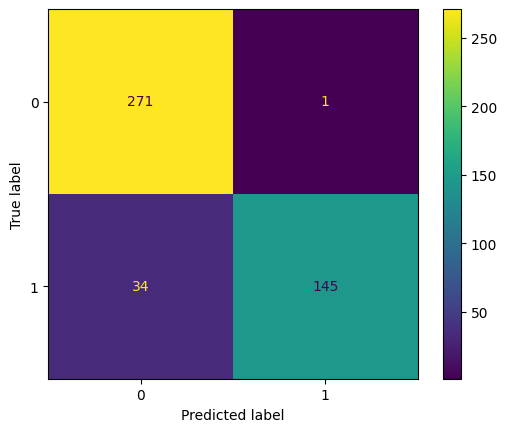

In [21]:
sv = SVC()
cv_results = cross_validate(sv, X_train, y_train, cv=skf, scoring=scoring)
print("SVM Classifier")
sv.fit(X_train, y_train)
y_pred = sv.predict(X_test)
scores(y_test, y_pred)
with open('models/sv.pkl', 'wb') as f:
    pk.dump(sv, f)

## Unsupervised Learning Models

### K-Means

KMeans Classifier
Accuracy:  0.48558758314855877
Precision:  0.37320574162679426
Recall:  0.43575418994413406
F1 Score:  0.4020618556701031
ROC AUC Score:  0.4770682714426552
[[141 131]
 [101  78]]


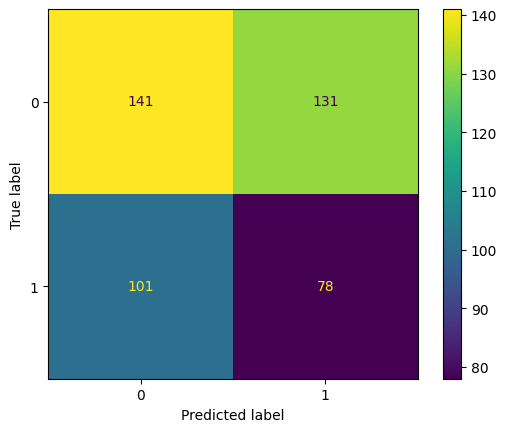

In [22]:
km = KMeans(n_clusters=2, random_state=69)
cv_results = cross_validate(km, X_train, y_train, cv=skf, scoring=scoring)
print("KMeans Classifier")
km.fit(X_train, y_train)
y_pred = km.predict(X_test)
scores(y_test, y_pred)
with open('models/km.pkl', 'wb') as f:
    pk.dump(km, f)

### Gaussian Mixture Model (GMM)

Gaussian Mixture Classifier
Accuracy:  0.49889135254988914
Precision:  0.1780821917808219
Recall:  0.07262569832402235
F1 Score:  0.10317460317460317
ROC AUC Score:  0.42601873151495234
[[212  60]
 [166  13]]


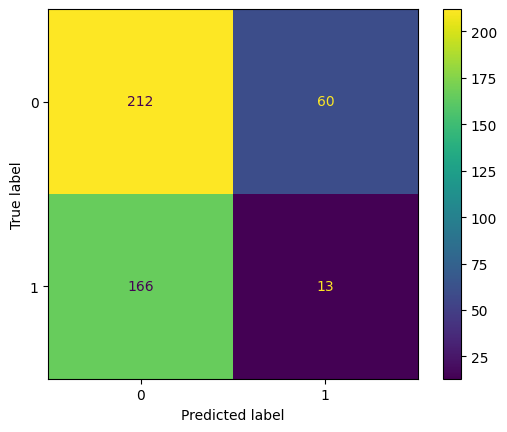

In [23]:
gmm = GaussianMixture(n_components=2, random_state=69)
cv_results = cross_validate(gmm, X_train, y_train, cv=skf, scoring=scoring)
print("Gaussian Mixture Classifier")
gmm.fit(X_train, y_train)
y_pred = gmm.predict(X_test)
scores(y_test, y_pred)
with open('models/gmm.pkl', 'wb') as f:
    pk.dump(gmm, f)

## Hyperparameter Tuning for RF

/home/yash/Codes/ML/asthma-detection-ml/.env/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest Classifier Grid Search
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.953276749370033
Accuracy:  0.9623059866962306
Precision:  0.9939024390243902
Recall:  0.9106145251396648
F1 Score:  0.9504373177842566
ROC AUC Score:  0.9534690272757148
[[271   1]
 [ 16 163]]


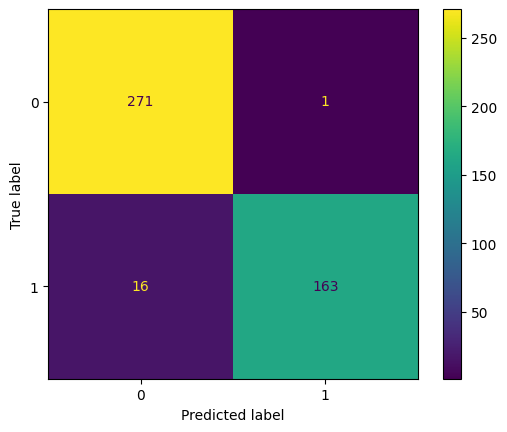

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring=scoring, refit='roc_auc')
grid_search.fit(X_train, y_train)
print("Random Forest Classifier Grid Search")
print(grid_search.best_params_)
print(grid_search.best_score_)
y_pred = grid_search.predict(X_test)
scores(y_test, y_pred)
with open('models/rf_grid.pkl', 'wb') as f:
    pk.dump(grid_search, f)


## User Interface

Accuracy:  0.7982261640798226
Precision:  0.84375
Recall:  0.6033519553072626
F1 Score:  0.7035830618892508
ROC AUC Score:  0.7649112717712784
[[252  20]
 [ 71 108]]


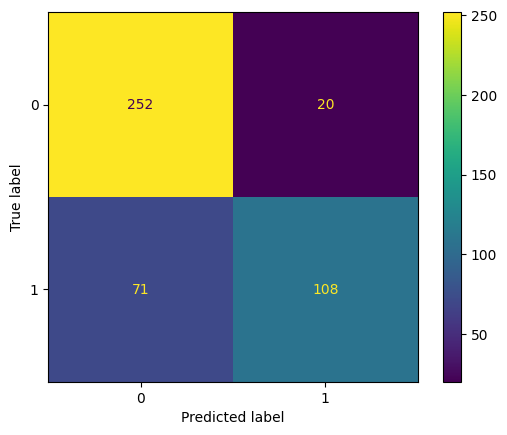

/home/yash/Codes/ML/asthma-detection-ml/.env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [25]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

X_train_new=X_train
feature_names=X_train_new.columns
X_test_new=X_test
model_1=DecisionTreeClassifier(random_state=69,max_depth=4)
model_1.fit(X_train_new,y_train)
pred_1=model_1.predict(X_test_new)
scores(y_test, pred_1)
# save model
filename = 'models/visual_dt.pkl'
pk.dump(model_1, open(filename, 'wb'))

class_names = ['No Asthma', 'Asthma']
pydotplus.find_graphviz = lambda: {"dot": r"C:\Program Files\Graphviz\bin\dot.exe"}

dot_data = tree.export_graphviz(model_1, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.replace('\n', ''))

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
for i in range(1):
    input_data = np.array(X_test_new.iloc[i])
    samples = input_data.reshape(1, -1)
    decision_paths = model_1.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
    filename = f'tree_{i+1}.png'
    graph.write_png(filename)

In [26]:
dt_modle = pk.load(open('models/visual_dt.pkl', 'rb'))

# Initialize an empty dataframe with the given columns
columns = [
    'Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure',
    'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema',
    'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1',
    'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness',
    'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Ethnicity_0',
    'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_0',
    'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3'
]
data_inputed = pd.DataFrame(columns=columns)

# Function to collect input and add to the dataframe
def submit_data():
    row = {}
    for col, entry in input_entries.items():
        value = entry.get()
        if col=='EducationLevel':
            if value==0:
                row['EducationLevel_0'] = 1
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 0
            elif value==1:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 1
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 0
            elif value==2:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 1
                row['EducationLevel_3'] = 0
            else:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 1
        else:
            row[col] = value
    # Append the row to the dataframe
    global data_inputed
    data_inputed = pd.concat([data_inputed, pd.DataFrame([row])], ignore_index=True)
    messagebox.showinfo("Success", "Data submitted successfully!")
    # Clear the entries after submission
    for entry in input_entries.values():
        entry.delete(0, tk.END)

# Function to save the dataframe to a CSV file
def save_data():
    data_inputed.to_csv("submitted_data.csv", index=False)
    messagebox.showinfo("Saved", "Data saved to 'submitted_data.csv'!")

# Create Tkinter window
root = tk.Tk()
root.title("Input Form")

# Create input fields for the selected columns
selected_columns = [
    'ChestTightness', 'HayFever', 'FamilyHistoryAsthma', 'Coughing',
     'HistoryOfAllergies', 'PollutionExposure',
    'PetAllergy', 'EducationLevel', 'PhysicalActivity', 'ShortnessOfBreath',
    'PollenExposure', 'DietQuality'
]
input_entries = {}

# Add labels and entry fields to the form
for i, col in enumerate(selected_columns):
    label = tk.Label(root, text=col)
    label.grid(row=i, column=0, padx=10, pady=5, sticky='e')
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5, sticky='w')
    input_entries[col] = entry

# Add Submit and Save buttons
submit_button = tk.Button(root, text="Submit", command=submit_data)
submit_button.grid(row=len(selected_columns), column=0, pady=10, padx=10, sticky='e')

save_button = tk.Button(root, text="Save to CSV", command=save_data)
save_button.grid(row=len(selected_columns), column=1, pady=10, padx=10, sticky='w')

# Run the Tkinter main loop
root.mainloop()
print(data_inputed)

   Age Gender  BMI Smoking PhysicalActivity DietQuality SleepQuality  \
0  NaN    NaN  NaN     NaN                1           1          NaN   

  PollutionExposure PollenExposure DustExposure  ... NighttimeSymptoms  \
0                 1              1          NaN  ...               NaN   

  ExerciseInduced Ethnicity_0 Ethnicity_1 Ethnicity_2 Ethnicity_3  \
0             NaN         NaN         NaN         NaN         NaN   

  EducationLevel_0 EducationLevel_1 EducationLevel_2 EducationLevel_3  
0                0                0                0                1  

[1 rows x 32 columns]


In [ ]:
for col in data_inputed.columns:
    if data_inputed[col].isna().sum() > 0:
        nan_mask = data_inputed[col].isna()
        random_samples = X_train[col].dropna().sample(
                n=nan_mask.sum(), replace=True, random_state=42
        ).values
        data_inputed.loc[nan_mask, col] = random_samples


df_new_model=pk.load(open('models/visual_dt.pkl','rb'))
# print(data_inputed)
dot_data = tree.export_graphviz(df_new_model, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.replace('\n', ''))

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')


y_pred = df_new_model.predict(data_inputed)
print(y_pred)
for i in range(1):
    input_data = np.array(data_inputed.iloc[i])
    samples = input_data.reshape(1, -1)
    decision_paths = model_1.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
    filename = f'tree_predict1_{i+1}.png'
    graph.write_png(filename)
    image=Image.open('tree_predict1_4.png')
    image.show()

[0]


/home/yash/Codes/ML/asthma-detection-ml/.env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## SHAP

 97%|=================== | 872/902 [00:18<00:00]       

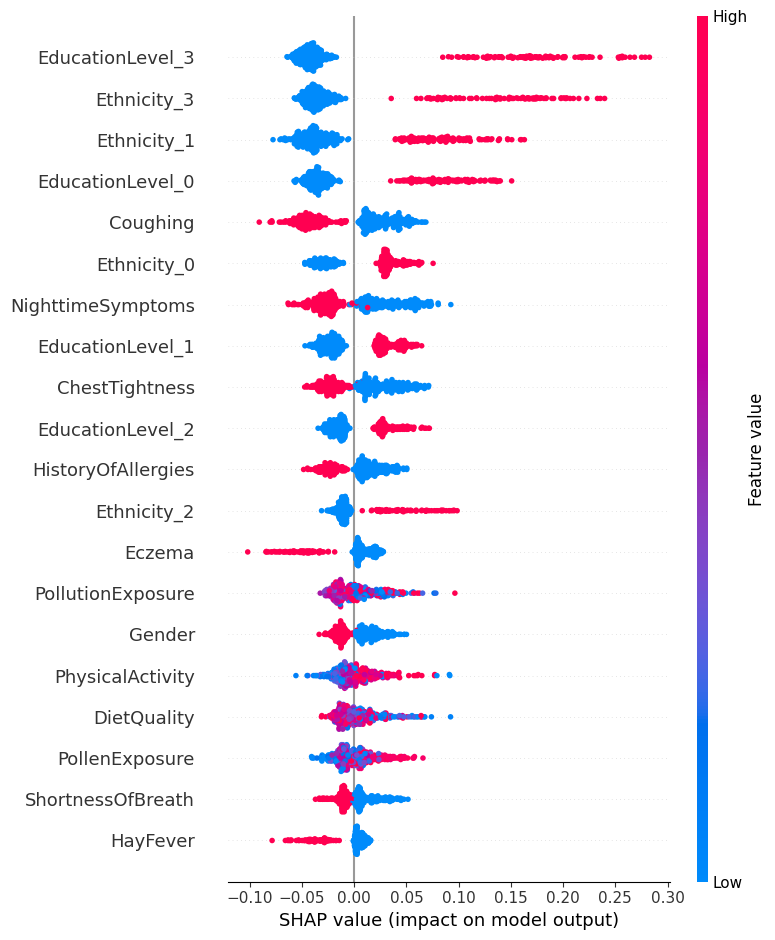

In [29]:
model=RandomForestClassifier(random_state=69)
X_train_new= X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['bool']).columns})
X_test_new = X_test_new.apply(pd.to_numeric, errors='coerce')

model.fit(X_train_new, y_train)
explainer = shap.Explainer(model, X_train_new)
X_test_new= X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['bool']).columns})
X_test_new = X_test_new.apply(pd.to_numeric, errors='coerce')
shap_values = explainer(X_test_new)
# print(shap_values)
shap_values_1=shap_values[:,:,1]
shap_values_2=shap_values[:,:,0]
shap.summary_plot(shap_values_1 ,X_test_new)
